In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import svm
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

import joblib
pd.set_option('display.max_columns', None)

## Loading Data

On garde l'ensemble des données et on concat

In [2]:
df = pd.read_csv('df_merged.csv')
df.shape

(243697, 16)

In [3]:
df.head(5)

,valeur_fonciere,code_departement,surface_reelle_bati,nombre_pieces_principales,surface_terrain,type_local,Month,Year,code_commune,Nb d'hôtels 2022,Population municipale 2019,Évol. annuelle moy. de la population 2013 - 2019 (en %) 2019,Nb de ménages 2018,Indice de vieillissement 2018,Hypermarché - Supermarché (en nombre) 2020,Lycée (en nombre) 2020
0,157000.0,18,128.0,4.0,604.0,Maison,1,2016,18033,17.0,64541.0,-0.7,32529.0,106.7,13.0,12.0
1,157000.0,18,128.0,4.0,452.0,Maison,1,2016,18033,17.0,64541.0,-0.7,32529.0,106.7,13.0,12.0
2,40000.0,18,51.0,2.0,204.0,Maison,1,2016,18096,0.0,2099.0,0.2,937.0,88.4,0.0,0.0
3,57000.0,18,33.0,4.0,431.0,Maison,1,2016,18279,11.0,25464.0,-1.0,12291.0,130.0,9.0,3.0
4,40000.0,18,34.0,3.0,942.0,Maison,1,2016,18148,1.0,2606.0,0.4,1093.0,94.5,0.0,0.0


## Data Preparation

Filtre uniquement sur les vente.

In [4]:
def modif(df):
  df = df.drop(columns=['code_commune'])
  df = df[df['type_local'] != 'Local industriel. commercial ou assimilé']
  df = df[df['type_local'] != 'Dépendance']
  df = df[df["valeur_fonciere"]< 2000000]
  df = df.dropna()
  
  return df

In [5]:
df_prep = modif(df)
df_prep.shape

(223668, 15)

## Features engineering

Stratify split sur le type de local pour preserver la proportion.

Dummification sur le type de local 

In [6]:
def define_data(data, column_predict):
    x = data.drop(columns=[column_predict]).values
    y = data[column_predict]
    return x, y

def dummification(data):
  dumm = pd.get_dummies(data, prefix=['type_local', 'code_departement'], columns=['type_local', 'code_departement'])
  return dumm

def Norm_Std_Scaler(data, columns):
    standard_scaler = StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = columns)
    return data_scaled

def train_test(X, y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8)
    return X_train, Y_train, X_test, Y_test

In [7]:
dumm = dummification(df_prep)
dumm.shape

x, y = define_data(dumm, 'valeur_fonciere')

x = Norm_Std_Scaler(x, ['surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'Month', 'Year', 'type_local_Appartement', ' type_local_Maison', 'code_departement_18', 'code_departement_28', 'code_departement_36', 'code_departement_37', 'code_departement_41', 'code_departement_45', 'Nb d\'hôtels 2022',	'Population municipale 2019',	'Évol. annuelle moy. de la population 2013 - 2019 (en %) 2019',	'Nb de ménages 2018',	'Indice de vieillissement 2018',	'Hypermarché - Supermarché (en nombre) 2020',	'Lycée (en nombre) 2020',])
X_train, Y_train, X_test, Y_test = train_test(x, y)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(178934, 20) (178934,)
(44734, 20) (44734,)


In [8]:
def score(model):
    y_pred_test = model.predict(X_test)
    predictions_test = [round(value, 4) for value in y_pred_test]

    print('MAE of predictions on testing : %s' % MAE(Y_test, predictions_test))
    print('MAPE of predictions on testing : %s' % MAPE(Y_test, predictions_test))

    print('R² on Testing set : ', model.score(X_test, Y_test))

def score_cv(model): 

    y_pred_test = model.predict(X_test)
    predictions_test = [round(value, 4) for value in y_pred_test]

    # evaluate predictions
    print('MAE of predictions on testing : %s' % MAE(Y_test, predictions_test))
    print('MAPE of predictions on testing : %s' % MAPE(Y_test, predictions_test))

    print('Best Score: %s' % model.best_score_)
    print('Best Hyperparameters: %s' % model.best_params_)

## Model Building

On veut un model un modele rapide d'execution avec ces données on peut esperer un bonne performance d'un model de boosting ou ensembliste. On choisit donc :
- Un ligtGBM
- Un extraTrees 

On utilisera un RandomizedSearch pour la recherche de parametres avec un repeatedKfold pour la cross validation

In [9]:
def Graph_prediction(data, y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    TP = data['valeur_fonciere']
    number = len(data['surface_reelle_bati'])
    aa=[x for x in data['surface_reelle_bati']]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, y[:number], 'o', label='Real value')
    plt.plot(aa, y_total[:number], 'x', label='Predicted value')
    
    plt.xlabel('Surface', size=15)
    plt.ylabel('Valeur Fonciere', size=15)
    plt.title('Valeur Fonciere Prediction')
    plt.legend(fontsize=15)
    plt.show()

In [10]:
def var_importance(modelcv):
	importance = modelcv.best_estimator_.feature_importances_# get importance

	for i,v in enumerate(importance): # summarize feature importance
		print('Feature: %0d, Score: %.5f' % (i,v))

	plt.bar([x for x in range(len(importance))], importance) # plot feature importance
	plt.show()

In [11]:
xtrees = ExtraTreesRegressor()
rfr = RandomForestRegressor()
lgb = lgb
sgd = SGDRegressor()
xgb = xgb
svr = svm.SVR()

rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)

xtrees_params = { 
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'bootstrap': [False, True]
}

rfr_params = {
    'max_depth': [10, 20, 40, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400, 600]
 }

lgb_params = {
    'max_depth': [10, 20, 30, 40, 100, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'n_estimators': [100, 200, 300, 400, 500, 1000, 1500],
}

### ExtraTrees

In [104]:
xtrees.fit(X_train, Y_train)
score(xtrees)

MAE of predictions on testing : 43948.17423365897
MAPE of predictions on testing : 84.43980096928361
R² on Testing set :  0.5858299005557668


In [105]:
xtrees_random = RandomizedSearchCV(xtrees,
                                xtrees_params,
                                cv=rkf,  
                                random_state=42, 
                                n_jobs=-1)

xtrees_random.fit(X_train, Y_train)
score_cv(xtrees_random)

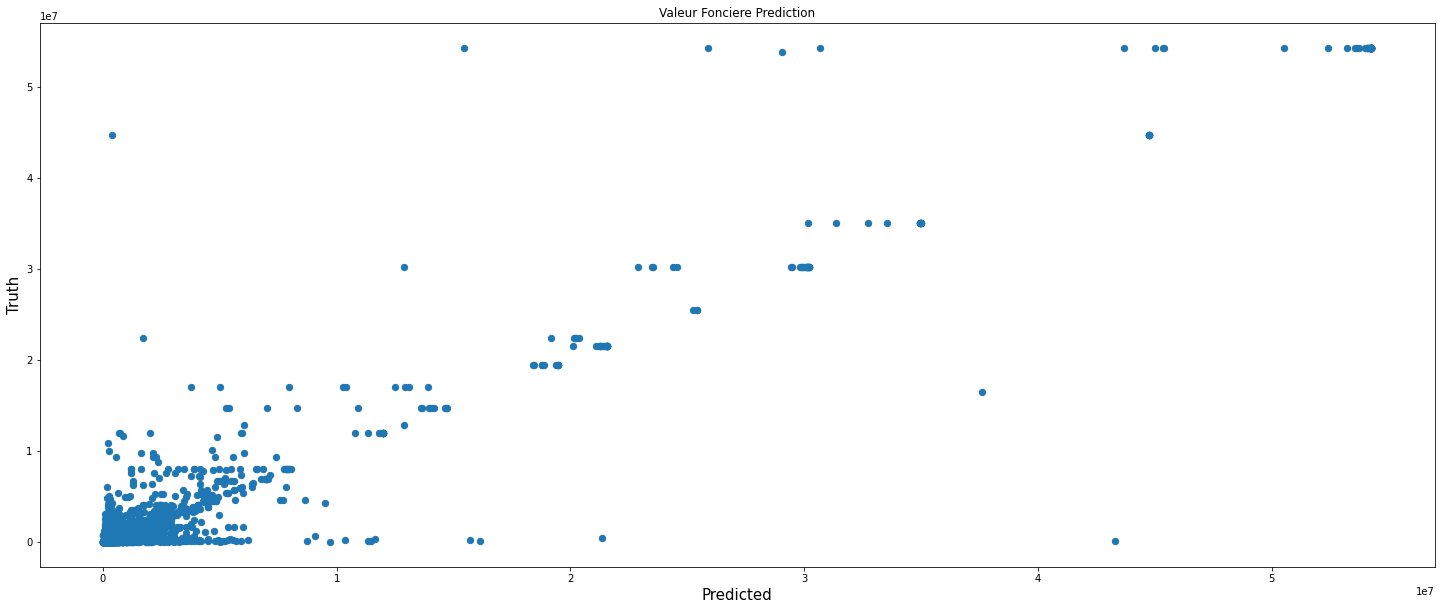

In [ ]:
plt.figure(figsize=(25,10)) 
plt.scatter(xtrees_random.predict(X_test), Y_test, s=40)

plt.xlabel('Predicted', size=15)
plt.ylabel('Truth', size=15)
plt.title('Valeur Fonciere Prediction')
plt.show()

Feature: 0, Score: 0.04813
Feature: 1, Score: 0.01588
Feature: 2, Score: 0.32837
Feature: 3, Score: 0.23554
Feature: 4, Score: 0.15435
Feature: 5, Score: 0.01323
Feature: 6, Score: 0.01758
Feature: 7, Score: 0.01337
Feature: 8, Score: 0.01530
Feature: 9, Score: 0.01292
Feature: 10, Score: 0.01494
Feature: 11, Score: 0.01374
Feature: 12, Score: 0.06706
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01081
Feature: 15, Score: 0.00664
Feature: 16, Score: 0.01665
Feature: 17, Score: 0.00535
Feature: 18, Score: 0.00009
Feature: 19, Score: 0.00178
Feature: 20, Score: 0.00108
Feature: 21, Score: 0.00720


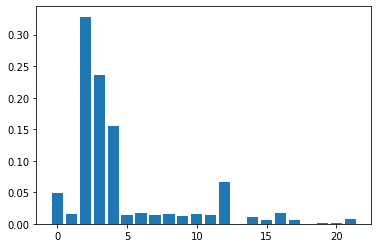

In [ ]:
var_importance(xtrees_random)

### Random Forest 

In [ ]:
rfr.fit(X_train, Y_train)
score(rfr)

MAE of predictions on testing : 91255.42384769388
MAPE of predictions on testing : 145.68244320290853
R² on Testing set :  0.9156910166878303


In [ ]:
rfr_random = RandomizedSearchCV(rfr,
                                rfr_params,
                                cv=2,  
                                random_state=42, 
                                n_jobs=-1)

rfr_random.fit(X_train, Y_train)
score_cv(rfr_random)

MAE of predictions on testing : 152383.42045164722
MAPE of predictions on testing : 1592.1847740796886
Best Score: 0.7779901220918765
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}


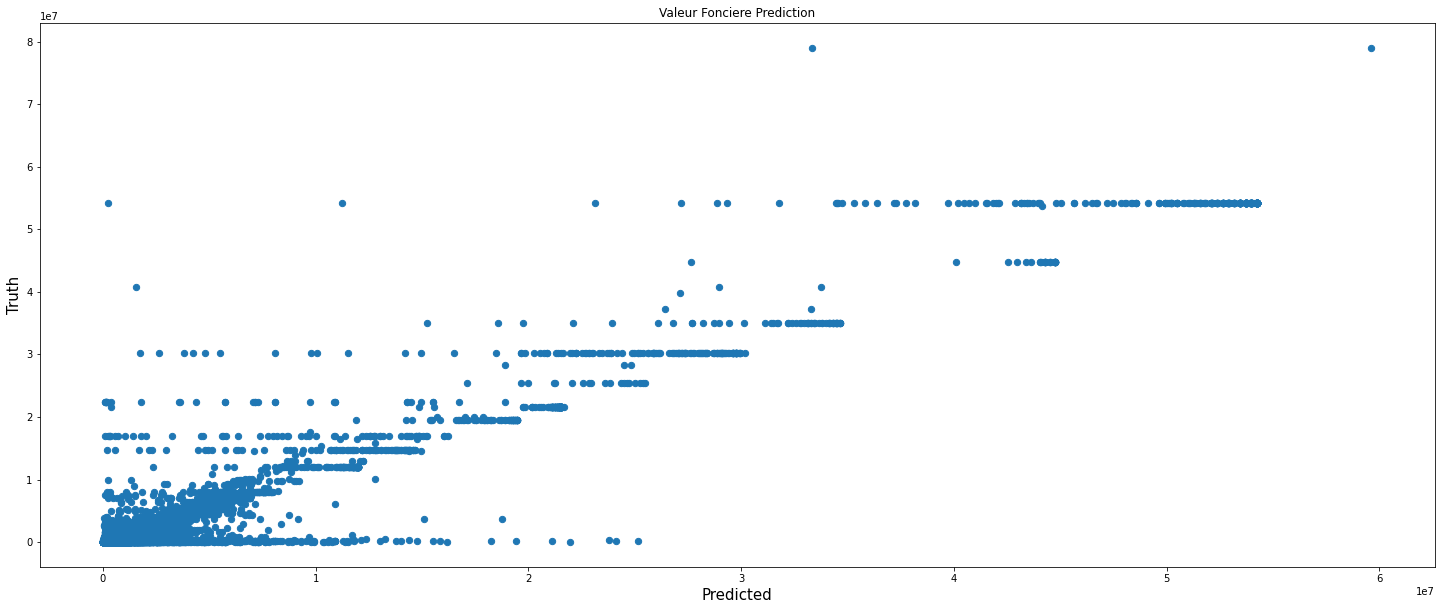

In [ ]:
plt.figure(figsize=(25,10)) 
plt.scatter(rfr_random.predict(x), y, s=40)

plt.xlabel('Predicted', size=15)
plt.ylabel('Truth', size=15)
plt.title('Valeur Fonciere Prediction')
plt.show()

### LightGBM

In [ ]:
lgb.fit(X_train, Y_train)
score(lgb)

MAE of predictions on testing : 126999.68948089053
MAPE of predictions on testing : 213.05885822467687
R² on Testing set :  0.8649089373073038


In [ ]:
lgb_random = RandomizedSearchCV(lgb,
                                lgb_params,
                                cv=rkf,  
                                random_state=42, 
                                n_jobs=-1)

lgb_random.fit(X_train, Y_train)
score_cv(lgb_random)

MAE of predictions on testing : 125064.79869876768
MAPE of predictions on testing : 215.6817691780209
Best Score: 0.891687510938155
Best Hyperparameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}


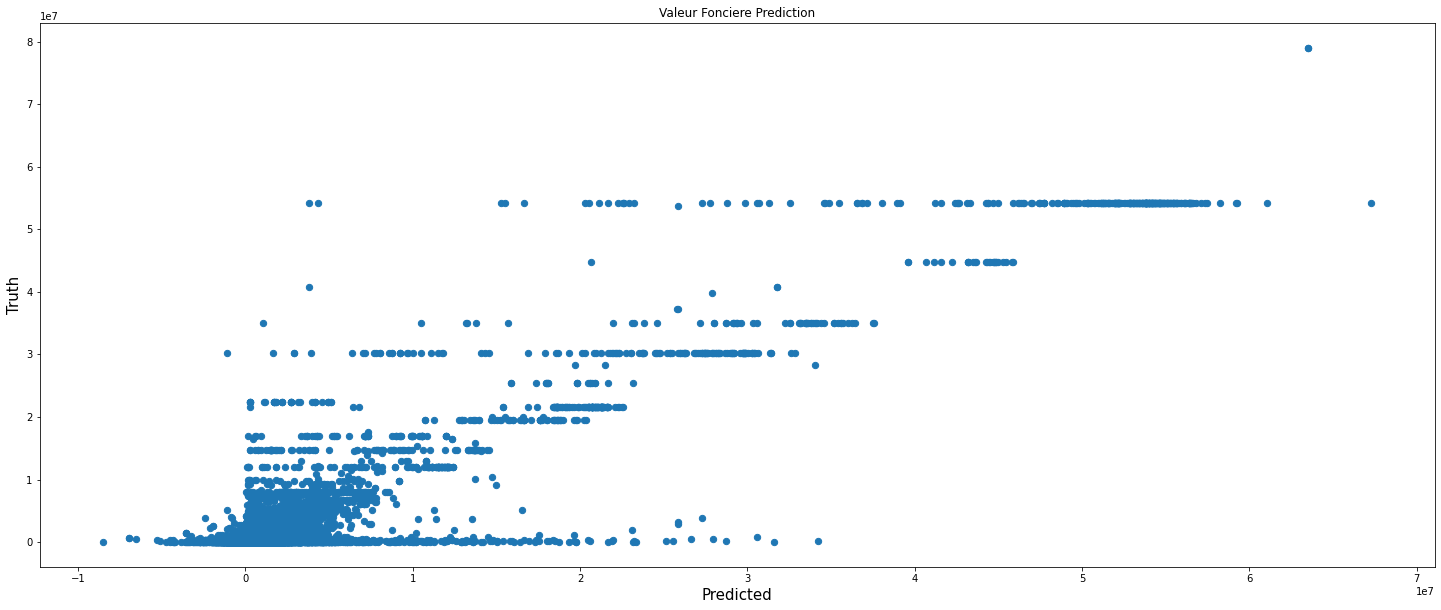

In [ ]:
plt.figure(figsize=(25,10)) 
plt.scatter(lgb_random.predict(x), y, s=40)

plt.xlabel('Predicted', size=15)
plt.ylabel('Truth', size=15)
plt.title('Valeur Fonciere Prediction')
plt.show()

Feature: 0, Score: 2225.00000
Feature: 1, Score: 819.00000
Feature: 2, Score: 2409.00000
Feature: 3, Score: 1303.00000
Feature: 4, Score: 1107.00000
Feature: 5, Score: 374.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 164.00000
Feature: 8, Score: 404.00000
Feature: 9, Score: 211.00000
Feature: 10, Score: 164.00000
Feature: 11, Score: 54.00000
Feature: 12, Score: 217.00000
Feature: 13, Score: 90.00000
Feature: 14, Score: 259.00000


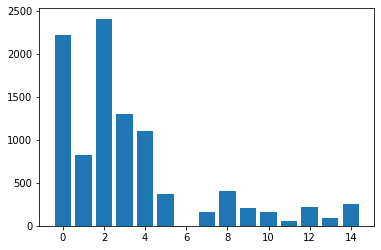

In [ ]:
var_importance(lgb_random)